# GSM

- 900MHz range composed of channels 0-124 with 200kHz spacing<br>
- modulation: 0.3GMSK (Gaussian minimum shift keying (frequency modulation)<br>
- frequency difference (for MSK): $\Delta f = 1/(2 \Delta t) = 135.416kHz $ ($\pm 67.708kHz$ around center frequency)<br>
- bitrate: 270.833kbit/s<br>

### Resources
http://www.cs.ru.nl/~fabianbr/pub/scriptie.pdf<br>

### frequencies

E-GSM-900:-----up:880.0–915.0-------down:925.0–960.0------ch:0-124<br>
R-GSM-900:-----up:876.0–915.0-------down:921.0–960.0------ch:0-124<br>
DCS-1800:------up:1710.2–1784.8-----down:1805.2–1879.8-----ch:512-885<br>

### GSMK Modulation
from: Digital cellular telecommunications system (Phase 2+);Modulation(GSM 05.04 version 8.1.2 Release 1999) [ETSI EN 300 959]

differential encoding of two bits at a time:
\begin{align}
\hat{d}_i = (d_{i-1}+d_{i}) \mod 2
\end{align}

modulation data:
\begin{align}
\alpha_i = 1 - 2\hat{d}_i \in \{-1,1\}
\end{align}

impulse response of filter:
\begin{align}
g(t) = rect\Big(\frac{t}{T}\Big) \circledast \frac{\exp\Big(\frac{-t^2}{2\delta^2T^2}\Big)}{\sqrt{2 \pi} \cdot \delta T}
\end{align}
with $\delta = \frac{\sqrt{\ln(2)}}{2\pi B T}$, where B is the 3dB bandwidth and T the time duration of one bit (for 0.3GMSK $BT=0.3$)

output phase:
\begin{align}
\phi(t) = \int_{t_0}^{t} \underbrace{\sum_i \alpha_i}_{\text{signal}} \cdot \frac{\pi}{2} \cdot \underbrace{g(u)}_{\text{impulse response}} du
\end{align}
where the current index i of $\alpha_i$ is dependent on time.<br>
This results in a phase shift of $\alpha \cdot \pi/2$ in the the output.

modulation:
\begin{align}
x(t) = \sqrt{\frac{2 E}{T}}\cos(2\pi f_0 t + \phi(t) + \phi_0)
\end{align}

### demodulation

From the bit encoding follows $\hat{d}_i = 1$ for $d_{i-1} = d_{i}$, else $\hat{d}_i = 0$ for $d_{i-1} \neq d_{i}$. This is a differential encoding and since the first bits of a message are known all other bits can be determined by measuring if the phase change was positive or negative.<br>

Because frequency is the time derivative of phase, in this modulation the frequency is varied with $\alpha_i g(t) = \pm g(t)$ around the carrier frequency with an overal phase change of $\pm \pi/2$ for every transmitted $\hat{d}_i$.<br>

### burst

Within a channel data is send in TDMA frames. A TDMA frame contains 8 burst wich are assigned to different mobile phones (time multiplexing).<br>
Uplink lags by 3 time slots (bursts) to the downlink and they are seperated by exactly 45mhz.<br>

<img src="gsm_burst.png" style="width:500px">

note:
- trail is composed of zeros
- guard is composed of ones

### data hirarchy

- 1 burst (576.9us)
- 8 bursts = TDMA frame (4.615ms)
- 26 TDMAs = traffic multiframe (120ms)
- 51 traffic multiframes = traffic superframe (6.12s)
- 51 TDMAs = control multiframe (235.4ms)
- 26 control multiframes = control superframe (6.12s)
- 2048 superframes = hyperframe (12533.76s)


### channels

<b style="font-size:15px">cch control channels (call setup, power adjustment)</b><br>
<b style="font-size:15px">tch traffic channels (voice, data)</b><br>

### identification

telefon number ---> imsi (nr obfuscation) ---> tmsi (temporary,to avoid tracking)


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d as gaussian
from scipy.signal import decimate,convolve
from rtlsdr import RtlSdr
from time import sleep

global pi,i
pi =np.pi
i = np.complex(0,1)

In [5]:
# configure device & capture data
freq = 935.2e+6
sample_rate = 2280000
bandwidth = 200e+3
nr_samples = 2**18
time_interval = nr_samples/sample_rate

sdr = RtlSdr()
sleep(1)
sdr.sample_rate = sample_rate
sdr.center_freq = freq
sdr.bandwidth = bandwidth
sdr.freq_correction = 60 #PPM
sdr.gain = 'auto'
samples = sdr.read_samples(nr_samples)
sdr.close()

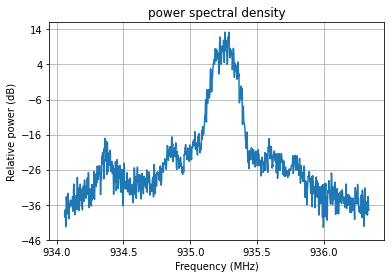

In [6]:
# power spectral density (sum of windowed fft)
from pylab import psd
psd(samples, NFFT=1024, Fs=sdr.sample_rate/1e6, Fc=sdr.center_freq/1e6)
plt.title('power spectral density')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative power (dB)')
plt.show()

Text(0, 0.5, 'amplitude')

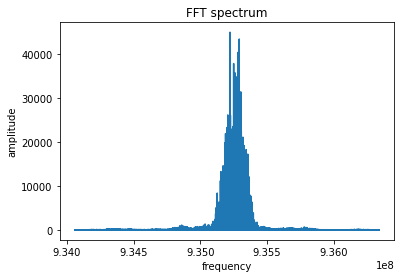

In [7]:
### simple fft spectrum
fig = plt.figure()
spectrum = np.fft.fftshift(np.fft.fft(samples))
frequencies = (np.arange(-nr_samples/2,nr_samples/2,1))*1/time_interval
plt.plot(freq + frequencies,abs(spectrum))
plt.title('FFT spectrum')
plt.xlabel('frequency')
plt.ylabel('amplitude')

In [169]:
#gsm burst and capture parameters
burst_time = 576.9e-6 #burst time
burst_symbols = 156.25 #bits per burst
bps = burst_symbols/burst_time #bits per second
sample_per_burst = sample_rate*burst_time
sample_per_bit = sample_per_burst/burst_symbols
print('bits per second: ',bps)
print('time per bit: ',1/bps)
print('samples captured per burst:',sample_per_burst)
print('samples per bit:',sample_per_bit)

bits per second:  270844.16710001737
time per bit:  3.6921599999999997e-06
samples captured per burst: 1315.3319999999999
samples per bit: 8.4181248


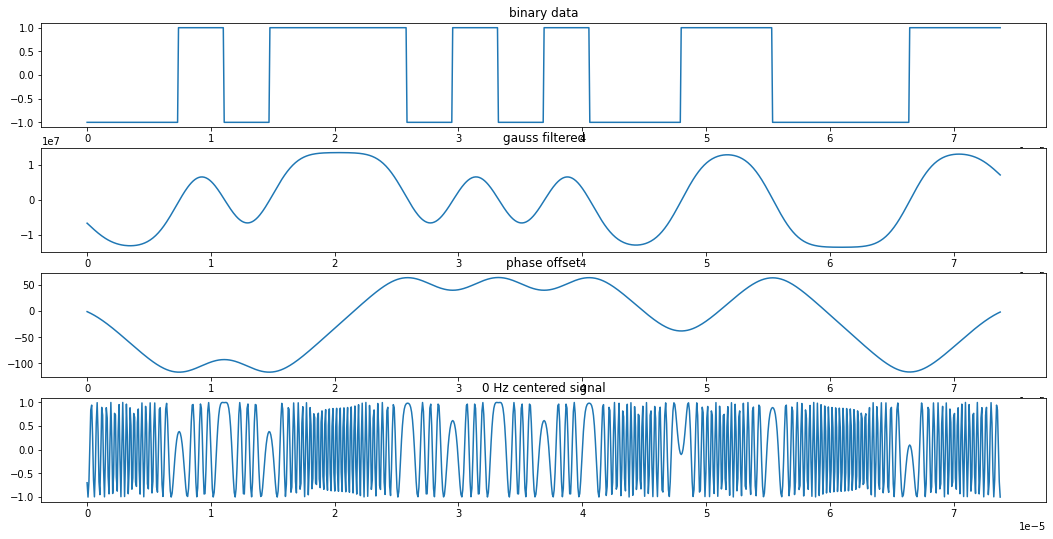

In [275]:
#simulation
#note: due to the high frequency of the carrier frequency the simulation is done
#around a carrier frequency of 0Hz. For this reason this simulation is simulating
#the observed data by the sdr rather than the original data
#(with possible phase and frequency offsets introduced by timing and frequency errors)

from mpl_toolkits.mplot3d import Axes3D

#gsm specs
T = 1/bps #time per symbol
BT=0.3
delta = np.sqrt(np.log(2))/(2*pi*BT)

#data parameters
N= 20 #data symbols
time_interval = T*N #overall time
n = 1000 #data samples
numN = n/N #samples per symbol
t = np.arange(0,time_interval,time_interval/n)

data = np.ones(n)
d = np.round(np.random.rand(N))
for ii in range(N):
    if d[ii]==1:
        data[int(ii*numN):int((ii+1)*numN)] = -1

gauss = np.exp(-(t-time_interval/2)**2/(2*delta**2*T**2))/(np.sqrt(2*pi)*delta*T)
filtered = convolve(data,gauss,mode='same')
summed = np.zeros(n)
summed[0] = filtered[0]*time_interval/n
for k in range(1,n):
    summed[k] = summed[k-1] + filtered[k]*time_interval/n

fig = plt.figure(figsize=(18,18))

plt.subplot(8,1,1)
plt.title('binary data')
plt.plot(t,data)

plt.subplot(8,1,2)
plt.title('gauss filtered')
plt.plot(t,filtered)

plt.subplot(8,1,3)
plt.title('phase offset')
plt.plot(t,summed*pi/2)

plt.subplot(8,1,4)
plt.title('0 Hz centered signal')
plt.plot(t,np.sin(summed*pi/2))

plt.show()

In [30]:
#plot start (start of burst in current captured samples)
c = 3620

Text(0, 0.5, 'amplitude')

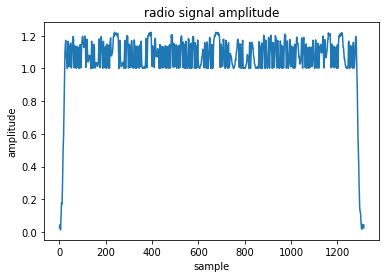

In [31]:
plt.plot(np.abs(samples[c:int(sample_per_burst)+c]))
plt.title('radio signal amplitude')
plt.xlabel('sample')
plt.ylabel('amplitude')

Text(0, 0.5, 'phase')

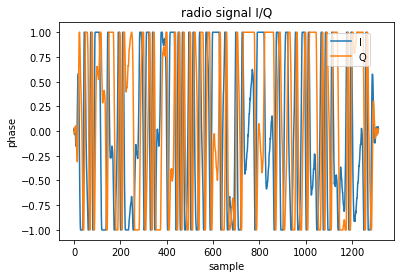

In [195]:
s = np.arange(int(sample_per_burst))
plt.plot(s,np.real(samples[c:int(sample_per_burst)+c]),label='I')
plt.plot(s,np.imag(samples[c:int(sample_per_burst)+c]),label='Q')
plt.legend(loc=(0.8,0.8))
plt.title('radio signal I/Q')
plt.xlabel('sample')
plt.ylabel('phase')

Text(0, 0.5, 'phase')

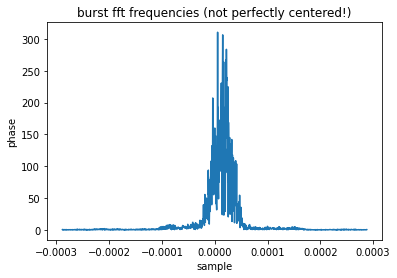

In [252]:
plt.plot(np.arange(-burst_time/2,burst_time/2,burst_time/int(sample_per_burst)),np.abs(np.fft.fftshift(np.fft.fft(samples[c:int(sample_per_burst)+c]))))
plt.title('burst fft frequencies (not perfectly centered!)')
plt.xlabel('sample')
plt.ylabel('phase')

Text(0.5, 0, 'Q')

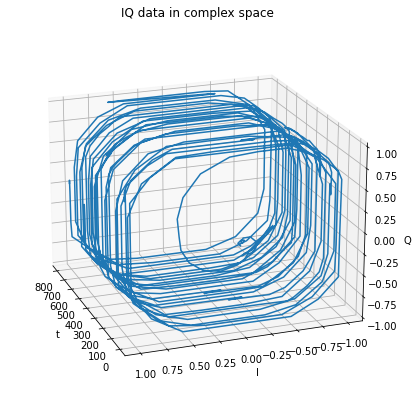

In [253]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(17,7))
ax = fig.add_subplot(111, projection='3d')
a = 800
ax.plot(np.arange(a),np.real(samples[c:c+a]),np.imag(samples[c:c+a]))
ax.view_init(20, 160)
plt.title('IQ data in complex space')
ax.set_xlabel('t')
ax.set_ylabel('I')
ax.set_zlabel('Q')

Text(0, 0.5, 'phase')

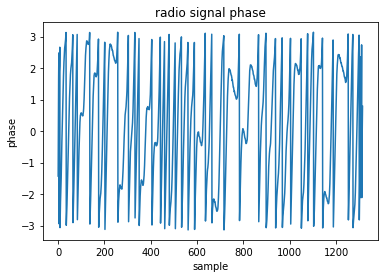

In [32]:
plt.plot(np.angle(samples[c:int(sample_per_burst)+c]))
plt.title('radio signal phase')
plt.xlabel('sample')
plt.ylabel('phase')

Text(0, 0.5, 'phase')

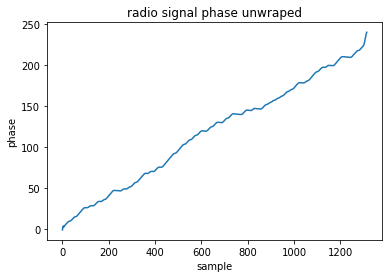

In [33]:
plt.plot(np.unwrap(np.angle(samples[c:int(sample_per_burst)+c])))
plt.title('radio signal phase unwraped')
plt.xlabel('sample')
plt.ylabel('phase')

Text(0, 0.5, 'phase change')

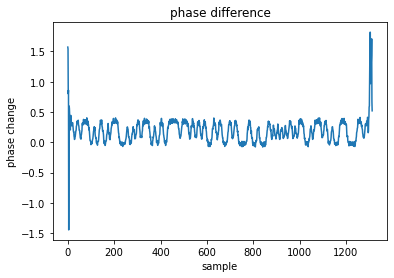

In [189]:
signal1 = np.diff(np.unwrap(np.angle(samples[c:int(sample_per_burst)+c])))
plt.plot(signal1)
plt.title('phase difference')
plt.xlabel('sample')
plt.ylabel('phase change')

### phase difference offset by capture frequency error
note: it just so happened that the frequency error while capturing the samples was approximately the modulation frequency step 67kHz. for this reason the lower phase difference is located at zero, hence the dips to zero in the complex (IQ data) plot.

Text(0.5, 0, 'Q')

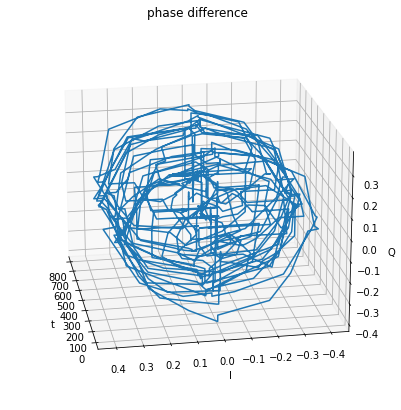

In [207]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(17,7))
ax = fig.add_subplot(111, projection='3d')
a = 800
difference = samples[c+1:c+a] - samples[c:c+a-1]
ax.plot(np.arange(a-1),np.real(difference),np.imag(difference))
ax.view_init(20, 170)
plt.title('phase difference')
ax.set_xlabel('t')
ax.set_ylabel('I')
ax.set_zlabel('Q')

Text(0, 0.5, 'phase change')

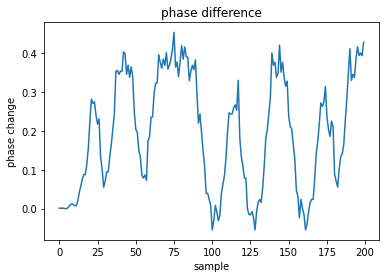

In [206]:
signal2 = np.real(samples)[1:]*np.diff(np.imag(samples)) - np.imag(samples)[1:]*np.diff(np.real(samples))
a = 200
plt.plot(signal2[c:c+a])
plt.title('phase difference')
plt.xlabel('sample')
plt.ylabel('phase change')